**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.


## Mengimpor Libraries yang dibutuhkan


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

!nvidia-smi




Num GPUs Available:  1
Thu Aug 31 10:13:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              N/A / ERR! |    140MiB /  3072MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## Preprocessing Datasets


In [2]:
from PIL import Image
from imutils import paths
import os
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images("dataset"))  # Dataset Penelitian
data = []
labels = []

# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)

# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


c:\Users\georg\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Input gambar berhasil


### Membuat objek ImageDataGenerator dan Data Augmentation


In [3]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 80% : 20% )

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=42)

# Membentuk training image generator untuk data augmentation

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [4]:
# Melihat jumlah data dalam set pelatihan
num_train_samples = trainX.shape[0]
print("Jumlah data pelatihan:", num_train_samples, " Citra")

# Melihat jumlah data dalam set pengujian
num_test_samples = testX.shape[0]
print("Jumlah data pengujian:", num_test_samples, " Citra")

Jumlah data pelatihan: 3066  Citra
Jumlah data pengujian: 767  Citra


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)


In [5]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# baseModel = tf.keras.applications.VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))


### Feature Extraction


In [6]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model


In [7]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False

# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)


model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 

### Melakukan Pelatihan Model


In [9]:
import time

# ...

print("Training head model...")

start_time = time.time()  # Memulai penghitungan waktu

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose=1)

end_time = time.time()  # Mengakhiri penghitungan waktu
training_duration = end_time - start_time  # Menghitung durasi waktu pelatihan dalam detik

# ...

print(f"Training completed in {training_duration:.2f} seconds.")  # Menampilkan durasi waktu pelatihan


Training head model...
Epoch 1/100
95/95 [==============================] - 87s 778ms/step - loss: 0.7166 - accuracy: 0.5728 - val_loss: 0.5959 - val_accuracy: 0.8801
Epoch 2/100
95/95 [==============================] - 48s 506ms/step - loss: 0.5938 - accuracy: 0.7337 - val_loss: 0.4999 - val_accuracy: 0.9153
Epoch 3/100
95/95 [==============================] - 45s 476ms/step - loss: 0.5012 - accuracy: 0.8303 - val_loss: 0.4193 - val_accuracy: 0.9309
Epoch 4/100
95/95 [==============================] - 49s 517ms/step - loss: 0.4320 - accuracy: 0.8866 - val_loss: 0.3552 - val_accuracy: 0.9361
Epoch 5/100
95/95 [==============================] - 44s 457ms/step - loss: 0.3694 - accuracy: 0.9153 - val_loss: 0.3023 - val_accuracy: 0.9452
Epoch 6/100
95/95 [==============================] - 45s 469ms/step - loss: 0.3325 - accuracy: 0.9163 - val_loss: 0.2622 - val_accuracy: 0.9518
Epoch 7/100
95/95 [==============================] - 45s 469ms/step - loss: 0.2928 - accuracy: 0.9281 - val_loss:

## Menampilkan Grafik Model Hasil Pelatihan


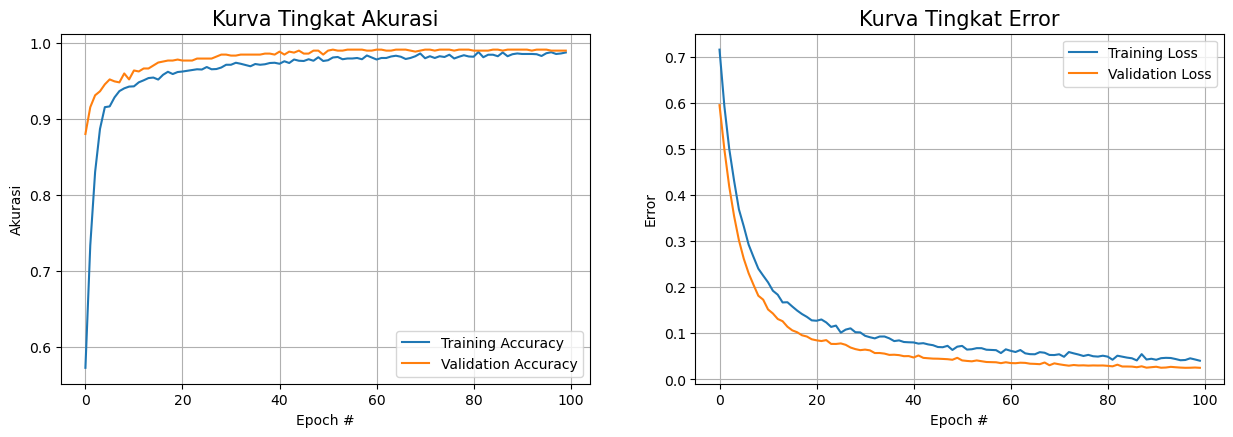

In [10]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N),
         H.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder=0)

plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder=0)
plt.show()

## Evaluasi Jaringan


In [12]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
'''
print(model.evaluate(x= testX, y = testY))
'''

print(model.evaluate(x=testX, y=testY))
# evaluasi fold

['loss', 'accuracy']
24/24 [==============================] - 16s 699ms/step - loss: 0.0252 - accuracy: 0.9896
[0.025156717747449875, 0.9895697236061096]


In [13]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

24/24 [==============================] - 8s 335ms/step
[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 

## Confusion Matrix


In [14]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [15]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[378,   5],
       [  3, 381]])

Text(0.5, 23.52222222222222, 'Label Prediksi')

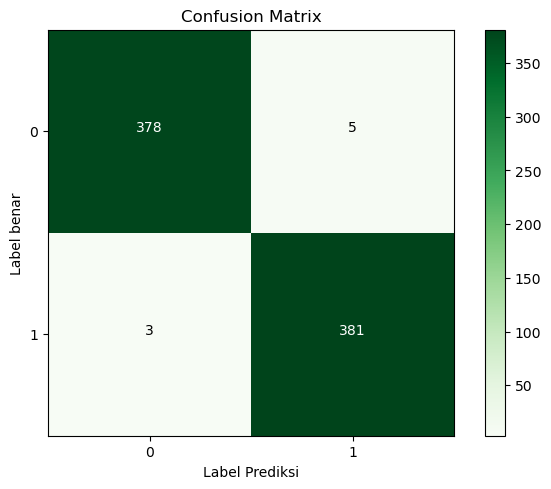

In [16]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

Analisis mAP


In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# menghitung nilai accuracy
accuracy = accuracy_score(yTrue, yPred)

# Menghitung nilai recall
recall = recall_score(yTrue, yPred)

# Menghitung nilai presisi
precision = precision_score(yTrue, yPred)

# Menghitung nilai F1-Score
f1 = f1_score(yTrue, yPred)

print("Akurasi:", accuracy)
print("Recall:", recall)
print("Presisi:", precision)
print("F1-Score:", f1)

Akurasi: 0.9895697522816167
Recall: 0.9921875
Presisi: 0.9870466321243523
F1-Score: 0.9896103896103896


In [18]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)

# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)

# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

24/24 [==============================] - 6s 269ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



## Menyimpan dan Konversi Model ke ".tflite"

Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.


In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
# Menyimpan model
tflite_model_file = pathlib.Path('face-mask-detection/content/model.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

# Pengujian Model dengan MTCNN


Model diujikan pada gambar dan secara real-time dengan menggunakan MTCNN yang digunakan untuk mendeteksi wajah.


In [ ]:
!pip install mtcnn

## Penggunaan Model pada Gambar


In [ ]:
from mtcnn import MTCNN
import cv2
# from google.colab.patches import cv2_imshow

In [ ]:
detector = MTCNN()
image = cv2.imread(
    'face-mask-detection/example_img/ex04.jpg', cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(image)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h

    # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
    face = image[y:y1, x:x1]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    # Membaca wajah dengan model
    (mask, withoutMask) = model.predict(face)[0]

    # Menggunakan masker hijau, tidak bermasker merah
    label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
    color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

    # Probabilitas hasil deteksi
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # Menampilkan hasil dengan label dan kotak
    cv2.putText(image, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x1, y1), color, 2)

# Menampilkan output
cv2.imshow(" Hasil", image)
cv2.waitKey(0)

## Pengujian Deteksi Perframe Capture


In [ ]:
# Mengimport lib
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import base64
import html
import io
import time

In [ ]:
def start_input():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display(js)


def take_photo(label, img_data):
    data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
    return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

In [ ]:
from google.colab.patches import cv2_imshow
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0

# Menginisialisasi MTCNN
detector = MTCNN()

while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)

    # Mengambil frame dari aliran video berulir dan
    # ukurannya maksimum lebar 400 pixel
    frame = image
    v = True
    if v == True:

        frame = imutils.resize(frame, width=400)

        faces = detector.detect_faces(frame)
        faces_list = []
        preds = []
        for result in faces:
            x, y, w, h = result['box']
            x1, y1 = x + w, y + h

            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
            face = image[y:y1, x:x1]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            faces_list.append(face)

            if len(faces_list) > 0:
                preds = model.predict(faces_list)

            # Mendeteksi bermasker atau tidak
            for pred in preds:
                (mask, withoutMask) = pred

                # Menggunakan masker hijau, tidak bermasker merah
            label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
            color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

            # Probabilitas pada label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # Menampilkan hasil dengan label dan kotak dari frame
            frame = cv2.putText(frame, label, (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            frame = cv2.rectangle(frame, (x, y), (x1, y1), color, 2)

            # Menampilkan ouput
            cv2_imshow(frame)

## Pengujian Streaming Video


In [ ]:
# import dependencies
from mtcnn import MTCNN
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
            js_reply: JavaScript object containing image from webcam
    Returns:
            img: OpenCV BGR image
    """
    # decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream


def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format(
        (str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display(js)


def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

In [ ]:
# Memulai streaming video dari webcam
video_stream()
# Label untuk video
label_html = 'Capturing...'
bbox = ''
count = 0
# Menginisialisasi MTCNN
detector = MTCNN()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Mengkonvert JS response ke OpenCV Image
    img = js_to_image(js_reply["img"])

    # Membuat transparan overlay untuk bounding box
    bbox_array = np.zeros([512, 512, 4], dtype=np.uint8)

    faces = detector.detect_faces(img)
    faces_list = []
    preds = []

    for result in faces:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h

        # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
        # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
        face = image[y:y1, x:x1]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        faces_list.append(face)

        if len(faces_list) > 0:
            preds = model.predict(faces_list)

        # Mendeteksi bermasker atau tidak
        for pred in preds:
            (mask, withoutMask) = pred

            # Menggunakan masker hijau, tidak bermasker merah
        label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
        color = (0, 255, 0) if label == "Bermasker" else (255, 0, 0)

        # Probabilitas pada label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # Menampilkan hasil dengan label dan kotak dari frame
        bbox_array = cv2.putText(
            bbox_array, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x1, y1), color, 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Mengkonversi overlay bbox ke dalam bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Mengupdate bbox ke pada frame selanjutnya untuk mendapat overlay
    bbox = bbox_bytes